# AI Camera DressCode

In [1]:
# Import Libraries
import os
import glob
import yaml
import cv2
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

plt.style.use("seaborn-v0_8")

In [2]:
# Load class names
def load_class_names(yaml_path="dataset/data.yaml"):
    with open(yaml_path, "r") as f:
        data = yaml.safe_load(f)
    return data["names"]

In [3]:
# Dataset Paths
splits = {
    "train": "dataset/train/labels",
    "valid": "dataset/valid/labels",
    "test": "dataset/test/labels"
}

image_label_splits = {
    "train": ("dataset/train/images", "dataset/train/labels"),
    "valid": ("dataset/valid/images", "dataset/valid/labels"),
    "test": ("dataset/test/images", "dataset/test/labels")
}

In [4]:
# load classes
class_names = ['Crop_Top', 'Miniskirt', 'Shorts', 'Sleeveless', 'low_neckline', 'ripped_pants', 'normal']
print("✅ Classes Loaded:", class_names)

✅ Classes Loaded: ['Crop_Top', 'Miniskirt', 'Shorts', 'Sleeveless', 'low_neckline', 'ripped_pants', 'normal']


## Data Analysis

In [5]:
# Classes Distribution
def compute_class_distribution(class_names, splits):
    distribution = {split: {cls: 0 for cls in class_names} for split in splits}
    
    for split, label_dir in splits.items():
        for label_file in glob.glob(os.path.join(label_dir, "*.txt")):
            with open(label_file, "r") as f:
                lines = f.readlines()
                if not lines:
                    distribution[split]["normal"] += 1
                else:
                    for line in lines:
                        cls_id = int(line.split()[0])
                        distribution[split][class_names[cls_id]] += 1
    return distribution

In [6]:
# calculate distribution
distribution = compute_class_distribution(class_names, splits)
df = pd.DataFrame(distribution).T
df

,Crop_Top,Miniskirt,Shorts,Sleeveless,low_neckline,ripped_pants,normal
train,309,315,287,710,349,206,120
valid,76,73,49,181,93,110,49
test,54,52,50,119,58,11,20


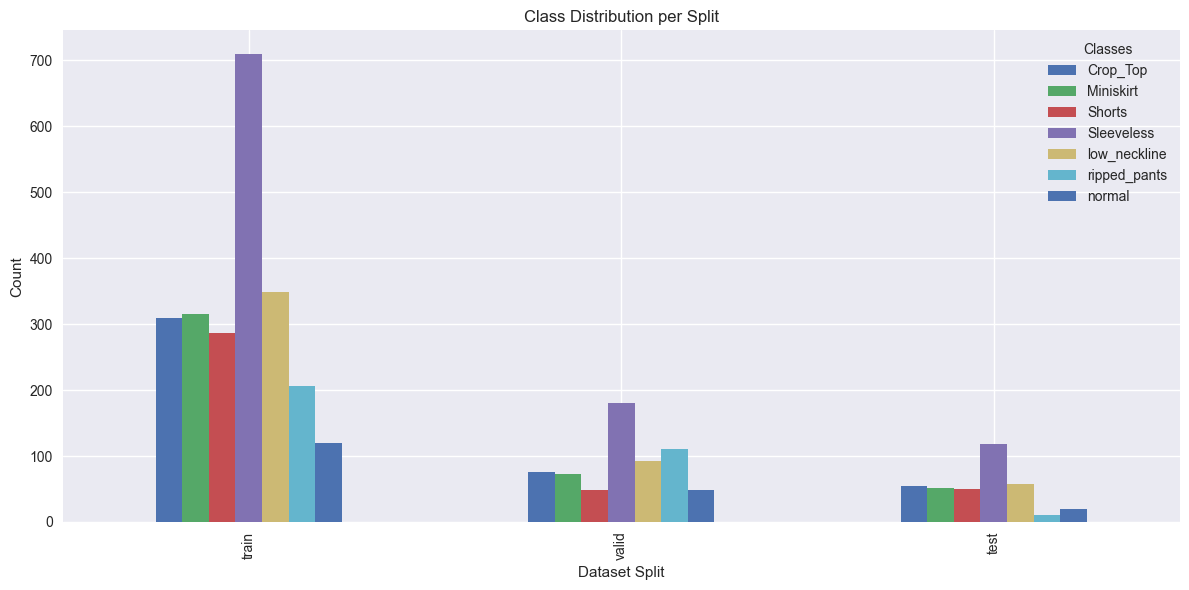

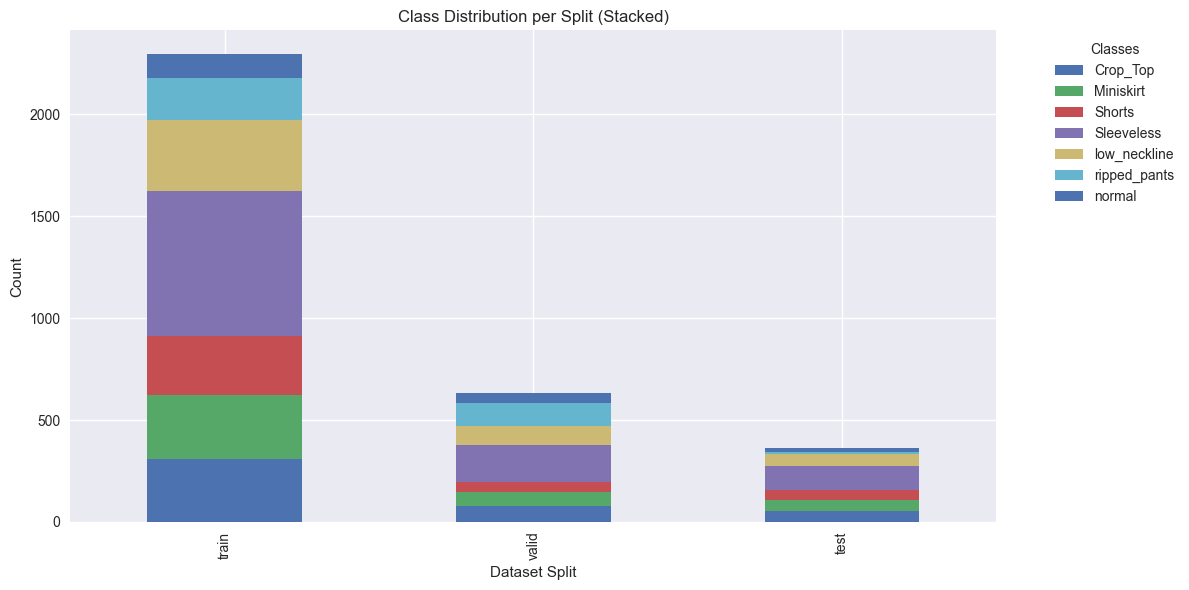

In [7]:
# 4. Plot Class Distribution
def plot_class_distribution(df):
    df.plot(kind="bar", figsize=(12,6))
    plt.title("Class Distribution per Split")
    plt.xlabel("Dataset Split")
    plt.ylabel("Count")
    plt.legend(title="Classes")
    plt.tight_layout()
    plt.show()

    df.plot(kind="bar", stacked=True, figsize=(12,6))
    plt.title("Class Distribution per Split (Stacked)")
    plt.xlabel("Dataset Split")
    plt.ylabel("Count")
    plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()
    
plot_class_distribution(df)

In [8]:
# 5. Objects & BBox Stats
def analyze_objects_and_bboxes(splits):
    objects_per_image, bbox_sizes = [], []

    for _, (img_dir, label_dir) in splits.items():
        for label_file in glob.glob(os.path.join(label_dir, "*.txt")):
            img_name = os.path.basename(label_file).replace(".txt", ".jpg")
            img_path = os.path.join(img_dir, img_name)

            img = cv2.imread(img_path)
            if img is None:
                continue
            h, w = img.shape[:2]

            with open(label_file, "r") as f:
                lines = f.readlines()
                objects_per_image.append(len(lines))

                for line in lines:
                    cls, x_center, y_center, bw, bh = map(float, line.strip().split())
                    bbox_area = (bw * w) * (bh * h) / (w * h)
                    bbox_sizes.append(bbox_area)

    return objects_per_image, bbox_sizes
objects_per_image, bbox_sizes = analyze_objects_and_bboxes(image_label_splits)

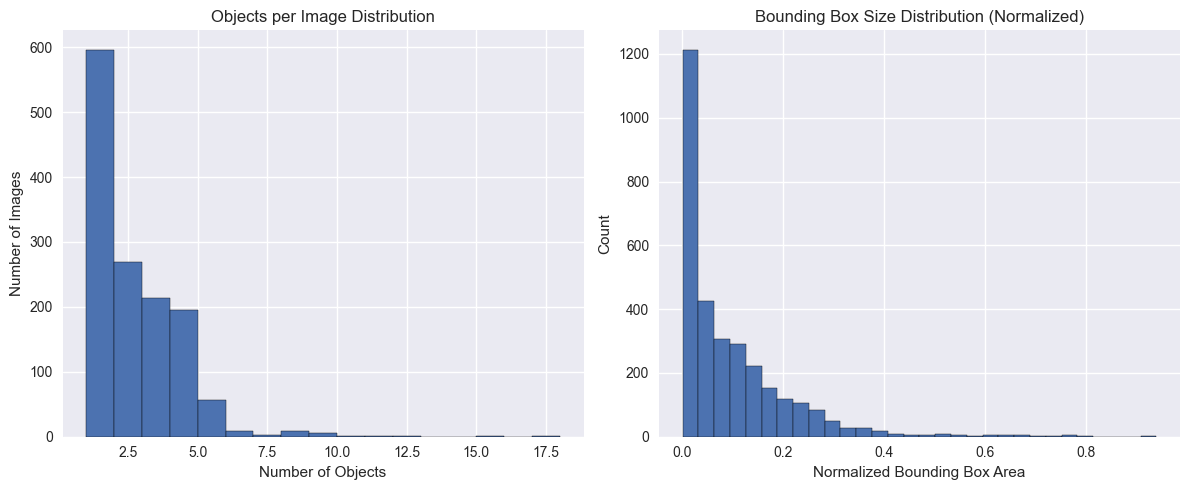

In [9]:
# 6. Plot Objects & BBox Stats
def plot_object_bbox_stats(objects_per_image, bbox_sizes):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.hist(objects_per_image, bins=range(1, max(objects_per_image)+2), edgecolor="black")
    plt.title("Objects per Image Distribution")
    plt.xlabel("Number of Objects")
    plt.ylabel("Number of Images")

    plt.subplot(1,2,2)
    plt.hist(bbox_sizes, bins=30, edgecolor="black")
    plt.title("Bounding Box Size Distribution (Normalized)")
    plt.xlabel("Normalized Bounding Box Area")
    plt.ylabel("Count")

    plt.tight_layout()
    plt.show()
plot_object_bbox_stats(objects_per_image, bbox_sizes)

## Preprocessing

In [10]:
# 7. Check Malformed Labels
def check_malformed_labels(lbl_dir):
    print(f"\n🔍 Checking: {lbl_dir}")
    for file in os.listdir(lbl_dir):
        if not file.endswith(".txt"):
            continue
        path = os.path.join(lbl_dir, file)
        with open(path, "r", encoding="utf-8") as f:
            lines = f.readlines()

        for i, line in enumerate(lines, 1):
            if len(line.strip().split()) != 5:
                print(f"⚠️ Malformed line in {file} (line {i}): {line.strip()}")

for _, label_dir in image_label_splits.values():
    check_malformed_labels(label_dir)


🔍 Checking: dataset/train/labels

🔍 Checking: dataset/valid/labels

🔍 Checking: dataset/test/labels


In [11]:
# 8. Convert Polygons → BBoxes
def polygon_to_bbox(points):
    xs, ys = points[::2], points[1::2]
    x_min, x_max, y_min, y_max = min(xs), max(xs), min(ys), max(ys)
    return ( (x_min + x_max) / 2, (y_min + y_max) / 2,
             x_max - x_min, y_max - y_min )

In [12]:
def fix_label_file(path, backup_dir):
    rel_path = os.path.relpath(path, start="dataset")
    backup_path = os.path.join(backup_dir, rel_path)
    os.makedirs(os.path.dirname(backup_path), exist_ok=True)
    shutil.copy(path, backup_path)

    fixed_lines = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) == 5:
                fixed_lines.append(line.strip())
            elif len(parts) > 5:
                cls, *coords = parts
                coords = list(map(float, coords))
                x, y, w, h = polygon_to_bbox(coords)
                fixed_lines.append(f"{cls} {x:.6f} {y:.6f} {w:.6f} {h:.6f}")

    with open(path, "w", encoding="utf-8") as f:
        f.write("\n".join(fixed_lines))


In [13]:
def process_all_labels():
    backup_dir = "labels_backup"
    os.makedirs(backup_dir, exist_ok=True)

    for split in ["train", "valid", "test"]:
        lbl_dir = f"dataset/{split}/labels"
        for file in os.listdir(lbl_dir):
            if file.endswith(".txt"):
                fix_label_file(os.path.join(lbl_dir, file), backup_dir)
    print("✅ All polygons converted to bounding boxes (backup in labels_backup)")

process_all_labels()

✅ All polygons converted to bounding boxes (backup in labels_backup)


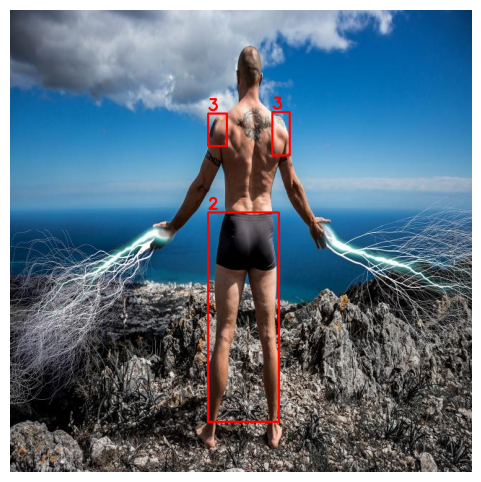

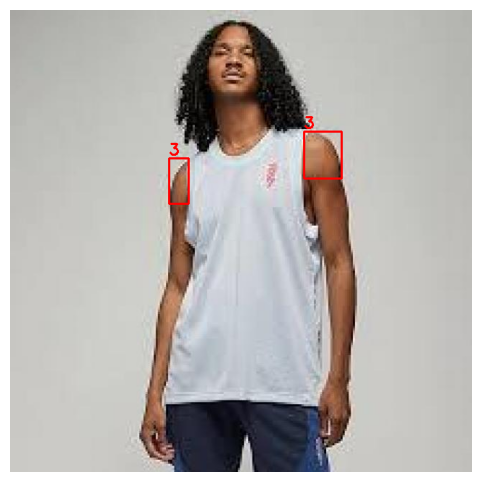

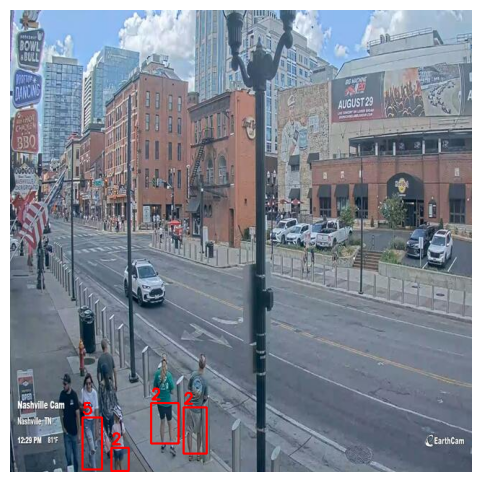

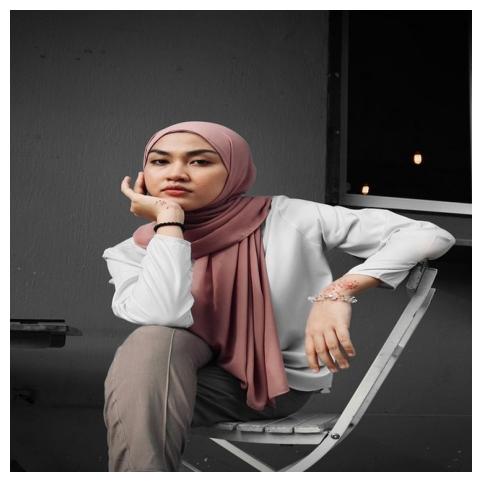

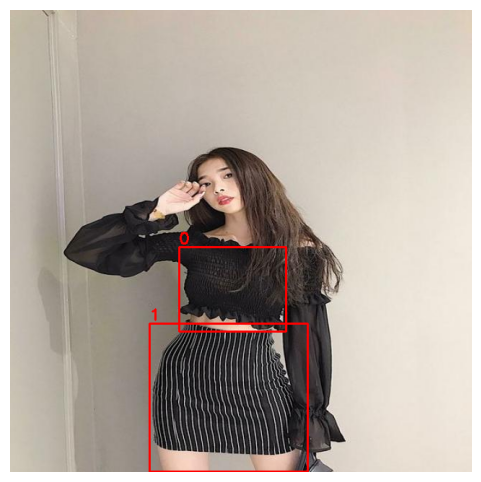

In [14]:
# 9. Visualize Sample Images
def visualize_sample_images(img_dir, label_dir, num_samples=5):
    sample_imgs = random.sample(os.listdir(img_dir), num_samples)

    for img_file in sample_imgs:
        img_path = os.path.join(img_dir, img_file)
        label_path = os.path.join(label_dir, img_file.replace(".jpg", ".txt"))

        img = cv2.imread(img_path)
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f.readlines():
                    cls, x, y, bw, bh = map(float, line.strip().split())
                    cls = int(cls)
                    x1, y1 = int((x - bw / 2) * w), int((y - bh / 2) * h)
                    x2, y2 = int((x + bw / 2) * w), int((y + bh / 2) * h)

                    cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)
                    cv2.putText(img, str(cls), (x1, y1 - 5),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)

        plt.figure(figsize=(6,6))
        plt.imshow(img)
        plt.axis("off")
        plt.show()
        
visualize_sample_images("dataset/train/images", "dataset/train/labels", num_samples=5)